   time in min  (S)-3-OH-PAC    3-OH-BA  (R)-3-OH-PAC  (S)-3-OH-PAC.1  \
0          0.0      0.031101  10.891257           0.0        0.027853   
1          0.5      1.883719   8.977816           0.0        0.077991   
2          1.0      3.631862   7.306264           0.0        0.143958   
3          1.5      5.212020   5.731909           0.0        0.143394   
4          2.0      6.713972   4.349994           0.0        0.240008   

   3-OH-BA.1  (R)-3-OH-PAC.1  
0   0.059094             0.0  
1   0.093238             0.0  
2   0.114549             0.0  
3   0.131286             0.0  
4   0.170337             0.0  
Index(['time in min', '(S)-3-OH-PAC', '3-OH-BA', '(R)-3-OH-PAC',
       '(S)-3-OH-PAC.1', '3-OH-BA.1', '(R)-3-OH-PAC.1'],
      dtype='object')


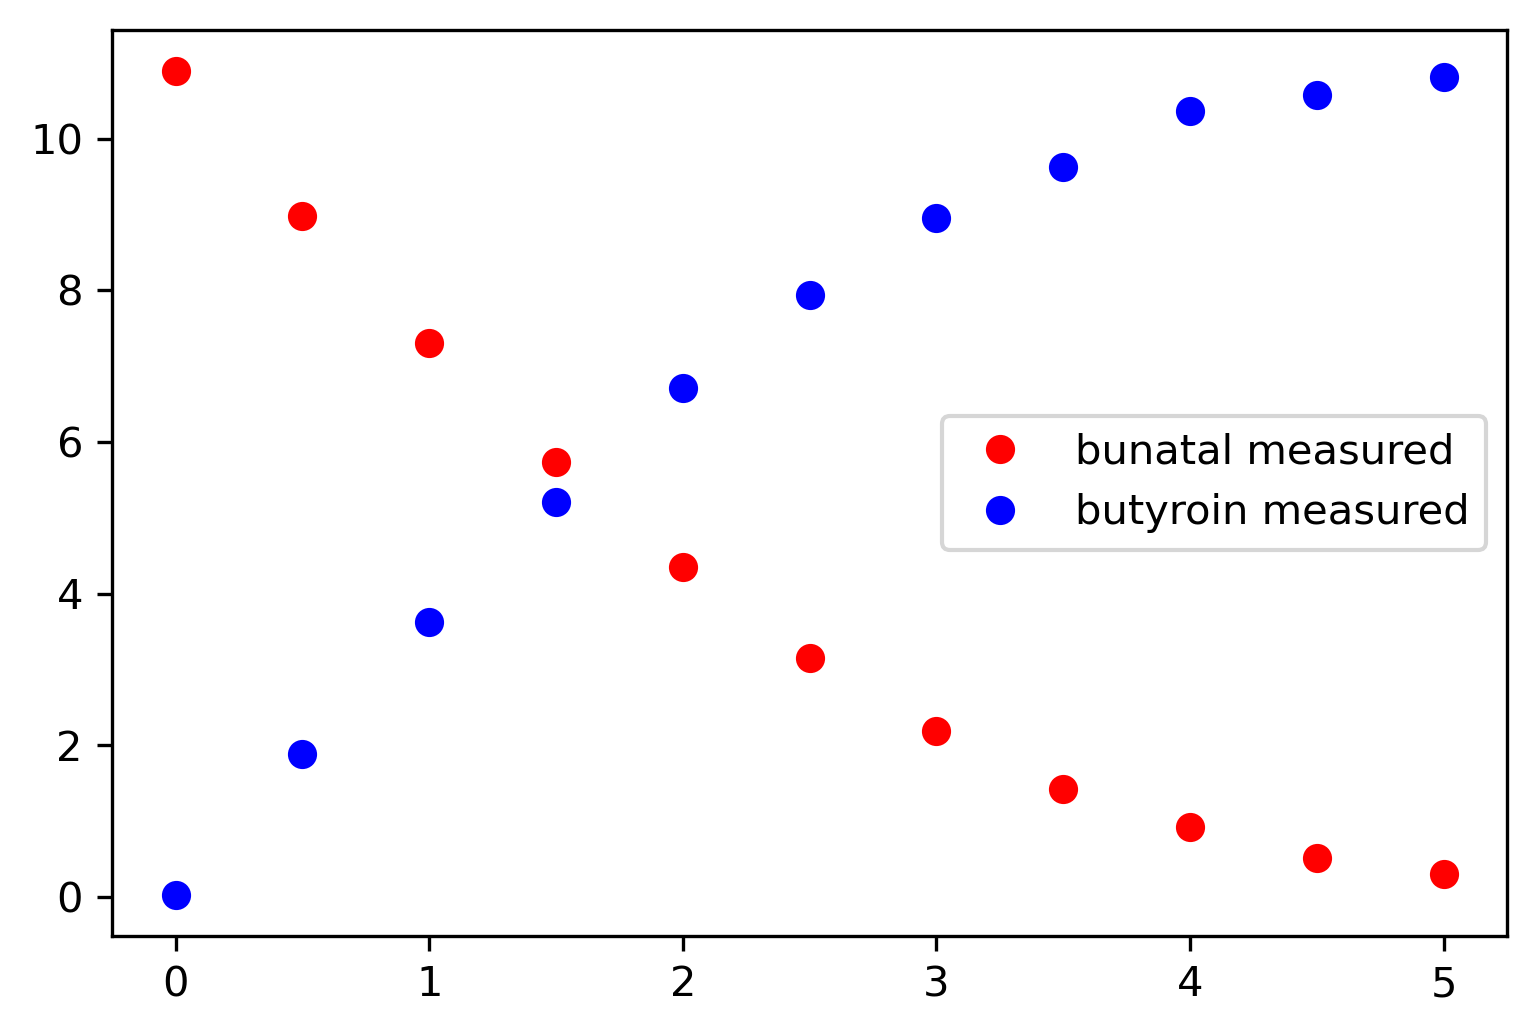

In [39]:
from scipy.integrate import odeint
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import lmfit

df = pd.read_excel(r"Full Conversion Approach.xlsx", sheet_name = "10mL_viualisation")
plt.rcParams["figure.dpi"] = 300
print(df.head())
print(df.columns)


time = df["time in min"]
substrate = df["3-OH-BA"]
product = df["(S)-3-OH-PAC"]

time_before_feed = time.iloc[:11]
substrate_before_feed = substrate.iloc[:11]
product_before_feed = product.iloc[:11]

fix, ax = plt.subplots()

ax.plot(time_before_feed, substrate_before_feed, label="bunatal measured", color="red", linestyle="", marker="o")
ax.plot(time_before_feed, product_before_feed, label="butyroin measured", color="blue", linestyle="", marker="o")
#ax.plot(time, product2, label="octanediol measured", color="green", linestyle="", marker="o")
ax.legend()





[[10.89125651  8.97781629  7.30626428  5.73190936  4.34999448  3.14620345
   2.18897357  1.4283044   0.92770542  0.51440539  0.30357097]
 [ 0.03110091  1.88371882  3.63186183  5.21201965  6.71397226  7.93279586
   8.95364052  9.62457475 10.35836504 10.57652435 10.81390784]]
[11, 0]
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 41
    # data points      = 22
    # variables        = 2
    chi-square         = 5.72100254
    reduced chi-square = 0.28605013
    Akaike info crit   = -25.6317647
    Bayesian info crit = -23.4496798
[[Variables]]
    kA:  0.50834051 +/- 0.03338610 (6.57%) (init = 2)
    kP:  1.3747e-10 +/- 0.10186993 (74102301001.87%) (init = 2)
[[Correlations]] (unreported correlations are < 0.100)
    C(kA, kP) = -0.831
None


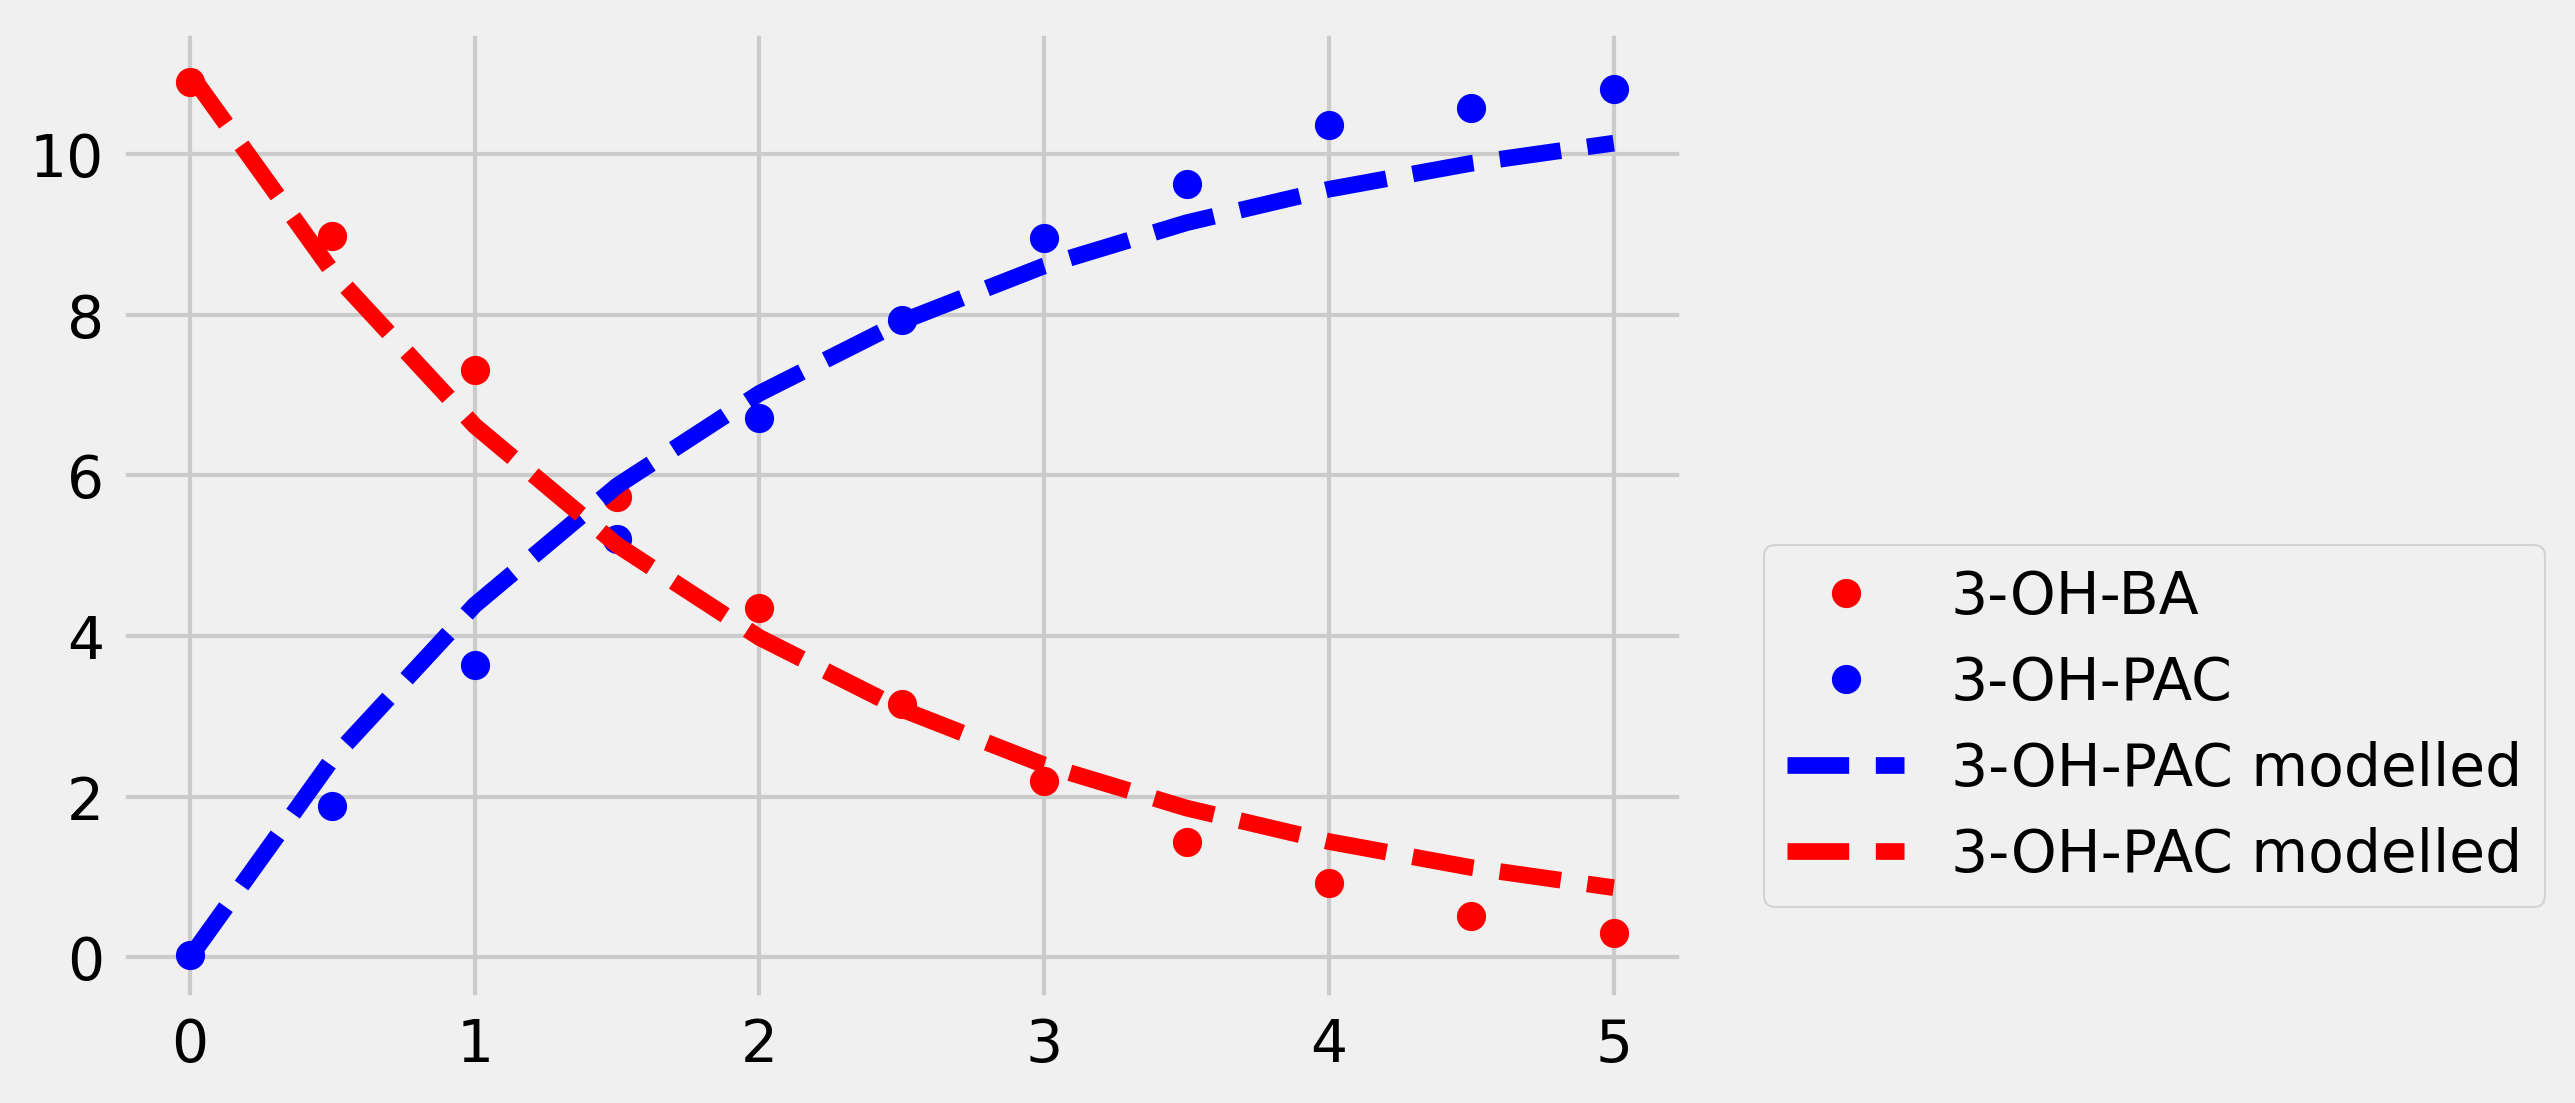

In [63]:
# Definition of DGL system
# A = Initial conditions
# t = time or x-values
# kA = Constant A
# kB = Constant B



data_list = [substrate_before_feed,product_before_feed]

data = np.array(data_list)

print(data)


y0_array = [11, 0]
print(y0_array)


def dadt(kA, kP, A,P, t):
    dadt = -kA*A + kP*P
    return dadt

def dbdt(kA, kP, A, P, t):
        dbdt = kA*A - kP*P 
        return dbdt



def dglsys(init_cond_array, t, kA, kP):
    A = init_cond_array[0]
    P = init_cond_array[1]
    dAdt = dadt(kA, kP, A, P, t)
    dBdt = dbdt(kA, kP, A, P,t)
    dZdt = np.array([dAdt, dBdt])
    return dZdt

    

sol = odeint(dglsys, y0_array, time_before_feed, args=(0.50834051, 0.000000000137))



params = lmfit.Parameters()
params.add('kA', 2, min=0.00000001, max=3)
params.add('kP', 2, min=0.0000000001, max=3)


def residual(params, time, data_sets):
    kA = params['kA'].value
    kP = params['kP'].value
    
    ymodel=odeint(dglsys, y0_array, time_before_feed, args=(kA, kP))
    substr = data_sets[0]-ymodel[:,0] # array 1
    product = data_sets[1]-ymodel[:,1] # array 2
    result = [substr, product] # result is returned as array
    return np.array(result)

solution = lmfit.minimize(residual, params, args=(np.array(time_before_feed), data))
print(lmfit.report_fit(solution))


fig, ax = plt.subplots()
plt.style.use('fivethirtyeight')
ax.plot(time_before_feed, substrate_before_feed, label="3-OH-BA", color="red", linestyle="", marker="o")
ax.plot(time_before_feed, product_before_feed, label="3-OH-PAC", color="blue", linestyle="", marker="o")

ax.plot(time_before_feed, sol[:,1], label="3-OH-PAC modelled", linestyle="--", color="blue")
ax.plot(time_before_feed, sol[:,0], label="3-OH-PAC modelled", linestyle="--", color="red")


ax.legend(loc=9, bbox_to_anchor=(1.3,0.5))
plt.savefig("testfig.svg", format="svg")
plt.show()

In [1]:


%matplotlib inline
import matplotlib.pyplot as plt
import pymc3 as pm
import numpy as np
import pandas as pd
import seaborn as sns



WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Generate example data


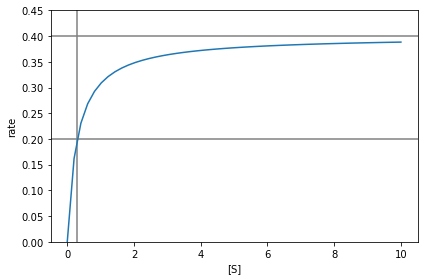

In [2]:
def mm_kinetics(s, Vmax, kM):
    return Vmax*s/(s + kM)


oVmax = 0.4
okm = .3
S = np.linspace(0, 10)



fig, ax = plt.subplots()

ax.axhline(oVmax, color='#808080')
ax.axhline(.5*oVmax, color='#808080')
ax.axvline(okm, color='#808080')
ax.plot(S, mm_kinetics(S, oVmax, okm))

ax.set(xlabel='[S]', ylabel='rate', ylim=(0, .45))

fig.tight_layout()



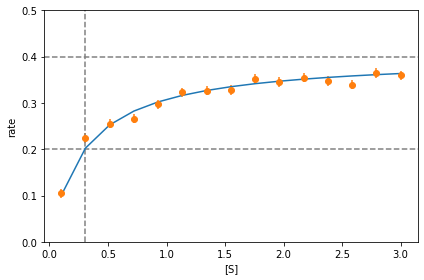

In [3]:


npoints = 15
S = np.linspace(.1, 3, npoints)
sigma = .01
rate = mm_kinetics(S, oVmax, okm) + np.random.normal(scale=sigma, size=(npoints))


fig, ax = plt.subplots()

ax.axhline(oVmax, color='#808080', linestyle='--')
ax.axhline(.5*oVmax, color='#808080', linestyle='--')
ax.axvline(okm, color='#808080', linestyle='--')
ax.plot(S, mm_kinetics(S, oVmax, okm))
ax.errorbar(S, rate, yerr=np.ones(npoints)*sigma, linestyle='none', marker='o')

ax.set(xlabel='[S]', ylabel='rate', ylim=(0, .5))

fig.tight_layout()


In [18]:
basic_model = pm.Model()

with basic_model:
    # parameters we want to estimate
    vmax = pm.Normal("vmax",0.3, 0.05)
    km = pm.Normal("km",0.2, 0.05)
    # our observable
    f = vmax * S / (km + S)
    # noise
    est_sigma = pm.Uniform('sigma', 0, .1)
    # our likelihood where we add our observed data
    likelihood = pm.Normal('L', mu=f, sd=est_sigma, observed=rate)
    # sampling
    start = pm.find_MAP()
    trace = pm.sample(5000, start=start)

c:\Users\SMalz\anaconda3\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  from ipykernel import kernelapp as app
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sigma, km, vmax]


Sampling 3 chains for 1_000 tune and 5_000 draw iterations (3_000 + 15_000 draws total) took 29 seconds.


In [5]:
#ppc = pm.sample_ppc(trace, model=basic_model, samples=50)

AttributeError: module 'pymc3' has no attribute 'sample_ppc'

c:\Users\SMalz\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  """Entry point for launching an IPython kernel.
Got error No model on context stack. trying to find log_likelihood in translation.
c:\Users\SMalz\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.


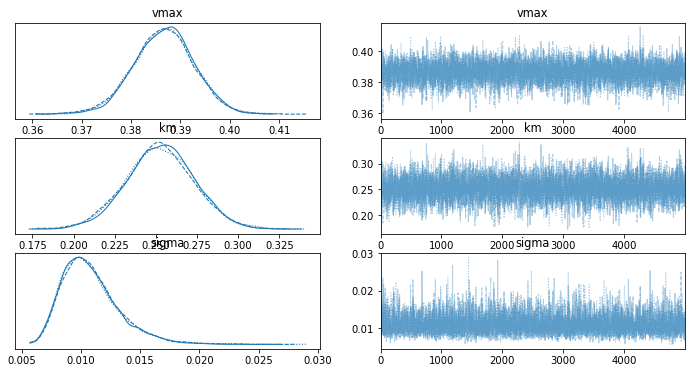

In [19]:
_ = pm.traceplot(trace)

Got error No model on context stack. trying to find log_likelihood in translation.
c:\Users\SMalz\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


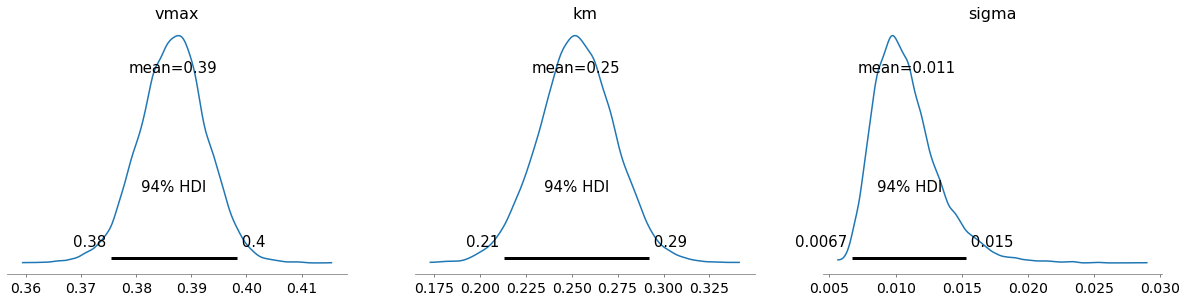

In [20]:
_ = pm.plot_posterior(trace)
